# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

from sklearn.model_selection import GridSearchCV

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
# Отдельный MSELoss, чтобы отслеживать влияние gamma на MSE. 
# (Не понял, как проще, так как minimize требует начального значения.
# Также непонятно, как вшить его веса в стандартный mean_squared_error)

def MSEloss(gamma: int, y: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(y - gamma*pred) ** 2 / y.shape[0]

In [4]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
        self.gammas = []        
        self.tree_pool = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (l, d)
        y - np.array of shape (l,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # print("Fit called")
        
        _y = y
        # print("IN fit")
        for _ in range(self.n_estimators):
            _prediction = self._fit_predict_tree(x, _y)
            y_new = _y - _prediction
            
#             print("Target value:", _y[10])
#             print("Prediction:", _prediction[10])
#             print("True value:", y[10])
#             print()
            
            _y = y_new

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        # print("_fit_predict_tree called")
        tree = DecisionTreeRegressor(max_depth=self.max_depth)        
        tree.fit(x, y)
        
        self.tree_pool.append(tree)
        
        _tree_prediction = tree.predict(x)
        
        gamma = minimize(MSEloss, 0, args=(y, _tree_prediction)).x # 0 -- стартовое значение
        self.gammas.append(gamma)
        
        return gamma * self.learning_rate * _tree_prediction
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # print("IN predict")
        y_pred = np.zeros(x.shape[0],)
        for i, tree in enumerate(self.tree_pool):
            # print(tree.predict(x)[10])
            y_pred += tree.predict(x)
        return y_pred * self.learning_rate * self.gammas[i]
   


    # Реализуем дополнительные методы для работы GridSearchCV
    def get_params(self, deep):
        return {'n_estimators':self.n_estimators, 'max_depth':self.max_depth, 'learning_rate':self.learning_rate}
    
    def set_params(self, **params):
        self.n_estimators = params['n_estimators']
        self.max_depth = params['max_depth']
        self.learning_rate = params['learning_rate']
        return self

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [5]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

---

In [7]:
%%time 

_n_estimators = range(1, 61, 1)
_max_depth = range(1, 11)
_learning_rate = np.arange(0.1, 1.0, 0.01)

data = []

for n_estimators in _n_estimators:
    print(n_estimators, end=' ')
    for max_depth in _max_depth:
        for learning_rate in _learning_rate:
            np.random.seed(19052019)

            gb = GradientBoosting(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            
            gb.fit(X_train, y_train)
            data.append((mean_squared_error(y_test, gb.predict(X_test)), n_estimators, max_depth, learning_rate))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 Wall time: 52min 46s


In [8]:
data[np.argmin(np.array(data)[:, 0])]

(9.44039002137813, 25, 6, 0.19999999999999996)

In [353]:
data

[(466.7820547610406, 1, 1, 0.1),
 (457.1575055088587, 1, 1, 0.11),
 (447.64529878114945, 1, 1, 0.12),
 (438.24543455765763, 1, 1, 0.13),
 (428.95791269288964, 1, 1, 0.13999999999999999),
 (419.78273300157554, 1, 1, 0.14999999999999997),
 (410.7198959991739, 1, 1, 0.15999999999999998),
 (401.7694011514881, 1, 1, 0.16999999999999998),
 (392.9312488273329, 1, 1, 0.17999999999999997),
 (384.20543925508593, 1, 1, 0.18999999999999995),
 (375.5919713807995, 1, 1, 0.19999999999999996),
 (367.0908462584213, 1, 1, 0.20999999999999996),
 (358.7020635366354, 1, 1, 0.21999999999999995),
 (350.42562321544193, 1, 1, 0.22999999999999995),
 (342.2615252948409, 1, 1, 0.23999999999999994),
 (334.2097702011499, 1, 1, 0.24999999999999992),
 (326.27035665541564, 1, 1, 0.2599999999999999),
 (318.4432862050826, 1, 1, 0.2699999999999999),
 (310.7285578927695, 1, 1, 0.2799999999999999),
 (303.1261717007204, 1, 1, 0.2899999999999999),
 (295.63612846905824, 1, 1, 0.29999999999999993),
 (288.25842706721846, 1, 1, 

In [16]:
np.random.seed(19052019)

custom_gb = GradientBoosting(n_estimators=25, max_depth=6, learning_rate=0.19999999999999996)

custom_gb.fit(X_train, y_train)
mean_squared_error(y_test, custom_gb.predict(X_test))

9.44039002137813

> **Победили случайный лес!** 

(И что, так всегда люди сидят в полной неопределённости до тех пор, пока сотни моделей на ГридСёрче не обучатся? И как жить, когда на результат влияют даже $20$ знаки после запятой???)

---

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- `Да` / Нет

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [19]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [3]:
train.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [4]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

# Пример из семинара
model_xgb = XGBClassifier(learning_rate=0.2,
                          n_estimators=100,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)
model_xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1])

0.7016246126532928

In [5]:
train.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

---

In [6]:
params1 = {
    'max_depth':range(2, 7, 1),
    'min_child_weight':range(2, 7, 1)
}
gscv = GridSearchCV(model_xgb, params1, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

0.7016538502340507

In [7]:
gscv.best_params_

{'max_depth': 5, 'min_child_weight': 3}

In [8]:
model_xgb.max_depth = gscv.best_params_['max_depth']
model_xgb.min_child_weight = gscv.best_params_['min_child_weight']

In [9]:
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

---

In [10]:
params2 = {
    'gamma': np.linspace(0, 2, 8) 
}
gscv = GridSearchCV(model_xgb, params2, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

0.7016538502340507

In [11]:
gscv.best_params_

{'gamma': 0.0}

In [12]:
model_xgb.gamma = gscv.best_params_['gamma']

---

In [13]:
params3 = {
    'subsample': np.arange(0.1, 1.1, 0.1),
    'colsample_bytree': np.arange(0.1, 1.1, 0.1)
}
gscv = GridSearchCV(model_xgb, params3, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

0.7016538502340507

In [14]:
gscv.best_params_

{'colsample_bytree': 1.0, 'subsample': 1.0}

In [15]:
model_xgb.subsample = 1
model_xgb.colsample_bytree = 0.9

---

In [23]:
params4 = {
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1, 100] 
}
gscv = GridSearchCV(model_xgb, params4, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

0.6986755181604805

In [24]:
gscv.best_params_

{'reg_alpha': 1, 'reg_lambda': 1e-05}

In [29]:
model_xgb.reg_alpha = 1
model_xgb.reg_lambda = 0

# Экспериментальные результаты

In [56]:
model_xgb.n_estimators = 3000
model_xgb.learning_rate = 0.01
model_xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1])

0.7005297500408825

> Стало лучше с перебором `n_estimators` и `learning_rate`! На целых $0.0002$!

# Экспериментальные результаты

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

In [60]:
np.random.seed(19052019)
model_gb = GradientBoostingClassifier(learning_rate=0.01, n_estimators=3000)

model_gb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1])

0.7040247716327603

> **И какой толк от XGBoost????????????????**

---

In [43]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=19052019, n_jobs=-1, max_depth=13, min_samples_split=3)

rf.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, rf.predict_proba(X_valid)[:, 1])

0.7072266858887791

### Выводы

Благодаря настройке XGBoost удалось добиться на результата $AUC\_ROC = 0.7409$ на трейне.
На тестовых значениях несмотря на перебор значений удаётся добиться улучшения лишь в разряде десятитысячных :( .

In [22]:
X_train

array([[ 732, 1934],
       [ 834, 1548],
       [ 416, 1422],
       ...,
       [1076, 1901],
       [ 140, 1515],
       [ 605, 1800]], dtype=int64)

In [23]:
_ = pd.DataFrame(X_train)

In [24]:
_[1] = list(map(lambda a: str(a // 100) + ':' + str(a % 100), X_train[:, 1]))

In [25]:
_

0      1
0       732  19:34
1       834  15:48
2       416  14:22
3       872  10:15
4       423  18:28
...     ...    ...
99995   199  16:18
99996   884    8:4
99997  1076   19:1
99998   140  15:15
99999   605   18:0

[100000 rows x 2 columns]

In [30]:
X_train_dummy = pd.get_dummies(data=_).to_numpy()

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
le = LabelEncoder()
le.fit(_[1])
_[1] = le.transform(_[1])

In [31]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train_dummy, y_train, test_size=0.3)

# Пример из семинара
model_xgb = XGBClassifier(learning_rate=0.6,
                          n_estimators=200,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)
model_xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1])

0.6804585061689126

In [32]:
X_train_part

array([[ 168, 1258],
       [ 361, 1272],
       [1121,  651],
       ...,
       [ 618, 1084],
       [ 413,  770],
       [ 409,  126]], dtype=int64)

In [33]:
params1 = {
    'max_depth':range(1, 8, 1),
    'min_child_weight':range(1, 8, 1)
}
gscv = GridSearchCV(model_xgb, params1, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

KeyboardInterrupt: 

In [69]:
gscv.best_params_

{'max_depth': 2, 'min_child_weight': 6}

In [70]:
model_xgb.max_depth = gscv.best_params_['max_depth']
model_xgb.min_child_weight = gscv.best_params_['min_child_weight']

In [78]:
params2 = {
    'gamma': np.linspace(0, 1, 30) 
}
gscv = GridSearchCV(model_xgb, params2, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

0.6996817450525563

In [79]:
gscv.best_params_

{'gamma': 0.27586206896551724}

In [80]:
model_xgb.gamma = gscv.best_params_['gamma']

In [81]:
params3 = {
    'subsample': np.arange(0.5, 1.1, 0.1),
    'colsample_bytree': np.arange(0.1, 1.1, 0.1)
}
gscv = GridSearchCV(model_xgb, params3, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

0.6996817450525563

In [83]:
gscv.best_params_

{'colsample_bytree': 1.0, 'subsample': 1.0}

In [84]:
model_xgb.subsample = gscv.best_params_['subsample']
model_xgb.colsample_bytree = gscv.best_params_['colsample_bytree']

In [94]:
params4 = {
    'reg_alpha': np.linspace(0.27, 0.30, 10) ,
    'reg_lambda': np.linspace(51, 54, 10)     
}
gscv = GridSearchCV(model_xgb, params4, scoring='roc_auc', n_jobs=-1)
gscv.fit(X_train_part, y_train_part)
gscv.best_score_

0.7002018715502141

In [95]:
gscv.best_params_

{'reg_alpha': 0.2733333333333334, 'reg_lambda': 51.333333333333336}

In [96]:
model_xgb.reg_alpha = gscv.best_params_['reg_alpha']
model_xgb.reg_lambda = gscv.best_params_['reg_lambda']

In [99]:
model_xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1])

0.6990645331870335

In [188]:
np.random.seed(19052019)
model_xgb = XGBClassifier(learning_rate=0.5,
                          n_estimators=750,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          max_depth=4,
                          min_child_weight=6,
                          gamma=0.27586206896551724,
                          subsample=1,
                          colsample_bytree=1,
                          reg_alpha=0.273333,
                          reg_lambda=51.3333333
                          )
model_xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1])

0.7005681030760568

In [57]:
np.random.seed(19052019)
model_xgb = XGBClassifier(learning_rate=0.01,
                          n_estimators=3000,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          max_depth=4,
                          min_child_weight=6,
                          gamma=0.27586206896551724,
                          subsample=1,
                          colsample_bytree=1,
                          reg_alpha=0.273333,
                          reg_lambda=51.3333333
                          )
model_xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, model_xgb.predict_proba(X_valid)[:, 1])

0.7040247716327603

> **Стало лучше на чуть-чуть...**

На **валидационной** выборке:

> Лучший результат после **OHE** DepTime и подстройки гиперпараметров: $0.6610125131515083$ :((  

> Лучший результат после **LabelEncoding** DepTime и подстройки гиперпараметров: $0.6990645331870335$ :((   

Понятия не имею, что ещё сделать, чтобы улучшить результат. Признаков нет, чтобы с ними работать. Разные кодировщики попробовали. Кучу гиперпараметров перебрали, в том числе тот пайплайн с семинара. НЕ ЗНАЮ ААААААААААААААААААААА

> _Поделитесь, пожалуйста, идеей, как можно было повысить качество на тесте... Очень много всего перепробовал, не могу понять и представить, как должен выглядеть хороший GB здесь..._

---

### CatBoost

In [62]:
!pip install catboost

In [96]:
X = pd.DataFrame(X_train_part)
X[1] = list(map(str, X[1]))
X.dtypes

X_v = pd.DataFrame(X_valid)
X_v[1] = list(map(str, X_v[1]))
X_v.dtypes

0     int64
1    object
dtype: object

In [46]:
from catboost import CatBoostClassifier, Pool
from catboost import MetricVisualizer

In [99]:
model = CatBoostClassifier(
    learning_rate=0.2,
    iterations=500,
    random_seed=0,
    train_dir='learing_rate_0.07'
)
model.fit(
    X, y_train_part,
    eval_set=(X_v, y_valid),
    verbose=True,
    cat_features=[1]
)


0:	learn: 0.6134873	test: 0.6139212	best: 0.6139212 (0)	total: 38.8ms	remaining: 19.4s
1:	learn: 0.5646314	test: 0.5654378	best: 0.5654378 (1)	total: 79.1ms	remaining: 19.7s
2:	learn: 0.5345712	test: 0.5357057	best: 0.5357057 (2)	total: 122ms	remaining: 20.2s
3:	learn: 0.5090703	test: 0.5093610	best: 0.5093610 (3)	total: 167ms	remaining: 20.7s
4:	learn: 0.4916348	test: 0.4912638	best: 0.4912638 (4)	total: 204ms	remaining: 20.2s
5:	learn: 0.4807980	test: 0.4790946	best: 0.4790946 (5)	total: 237ms	remaining: 19.5s
6:	learn: 0.4745342	test: 0.4719836	best: 0.4719836 (6)	total: 273ms	remaining: 19.2s
7:	learn: 0.4699405	test: 0.4668346	best: 0.4668346 (7)	total: 308ms	remaining: 19s
8:	learn: 0.4676140	test: 0.4641860	best: 0.4641860 (8)	total: 344ms	remaining: 18.8s
9:	learn: 0.4657802	test: 0.4619901	best: 0.4619901 (9)	total: 377ms	remaining: 18.5s
10:	learn: 0.4635324	test: 0.4598904	best: 0.4598904 (10)	total: 414ms	remaining: 18.4s
11:	learn: 0.4621231	test: 0.4585573	best: 0.4585573

97:	learn: 0.4517895	test: 0.4522447	best: 0.4522438 (90)	total: 3.85s	remaining: 15.8s
98:	learn: 0.4517600	test: 0.4522288	best: 0.4522288 (98)	total: 3.89s	remaining: 15.8s
99:	learn: 0.4517216	test: 0.4522444	best: 0.4522288 (98)	total: 3.93s	remaining: 15.7s
100:	learn: 0.4516542	test: 0.4522582	best: 0.4522288 (98)	total: 3.97s	remaining: 15.7s
101:	learn: 0.4516025	test: 0.4522536	best: 0.4522288 (98)	total: 4.01s	remaining: 15.7s
102:	learn: 0.4514892	test: 0.4522122	best: 0.4522122 (102)	total: 4.05s	remaining: 15.6s
103:	learn: 0.4514119	test: 0.4521968	best: 0.4521968 (103)	total: 4.1s	remaining: 15.6s
104:	learn: 0.4513791	test: 0.4522181	best: 0.4521968 (103)	total: 4.14s	remaining: 15.6s
105:	learn: 0.4513198	test: 0.4522108	best: 0.4521968 (103)	total: 4.18s	remaining: 15.5s
106:	learn: 0.4512789	test: 0.4522204	best: 0.4521968 (103)	total: 4.22s	remaining: 15.5s
107:	learn: 0.4512514	test: 0.4522078	best: 0.4521968 (103)	total: 4.25s	remaining: 15.4s
108:	learn: 0.45118

192:	learn: 0.4465208	test: 0.4514621	best: 0.4514621 (192)	total: 7.53s	remaining: 12s
193:	learn: 0.4464950	test: 0.4514504	best: 0.4514504 (193)	total: 7.57s	remaining: 11.9s
194:	learn: 0.4464717	test: 0.4514441	best: 0.4514441 (194)	total: 7.61s	remaining: 11.9s
195:	learn: 0.4463950	test: 0.4514598	best: 0.4514441 (194)	total: 7.64s	remaining: 11.9s
196:	learn: 0.4463314	test: 0.4514437	best: 0.4514437 (196)	total: 7.68s	remaining: 11.8s
197:	learn: 0.4463249	test: 0.4514460	best: 0.4514437 (196)	total: 7.72s	remaining: 11.8s
198:	learn: 0.4463095	test: 0.4514517	best: 0.4514437 (196)	total: 7.76s	remaining: 11.7s
199:	learn: 0.4462450	test: 0.4514317	best: 0.4514317 (199)	total: 7.81s	remaining: 11.7s
200:	learn: 0.4461916	test: 0.4514052	best: 0.4514052 (200)	total: 7.85s	remaining: 11.7s
201:	learn: 0.4461717	test: 0.4514059	best: 0.4514052 (200)	total: 7.89s	remaining: 11.6s
202:	learn: 0.4461110	test: 0.4514178	best: 0.4514052 (200)	total: 7.93s	remaining: 11.6s
203:	learn: 

287:	learn: 0.4426700	test: 0.4516898	best: 0.4512951 (215)	total: 11.2s	remaining: 8.21s
288:	learn: 0.4426461	test: 0.4516952	best: 0.4512951 (215)	total: 11.2s	remaining: 8.17s
289:	learn: 0.4426200	test: 0.4517060	best: 0.4512951 (215)	total: 11.2s	remaining: 8.13s
290:	learn: 0.4425446	test: 0.4517054	best: 0.4512951 (215)	total: 11.3s	remaining: 8.09s
291:	learn: 0.4424740	test: 0.4517482	best: 0.4512951 (215)	total: 11.3s	remaining: 8.05s
292:	learn: 0.4424413	test: 0.4517551	best: 0.4512951 (215)	total: 11.3s	remaining: 8.01s
293:	learn: 0.4424113	test: 0.4517484	best: 0.4512951 (215)	total: 11.4s	remaining: 7.97s
294:	learn: 0.4424083	test: 0.4517544	best: 0.4512951 (215)	total: 11.4s	remaining: 7.93s
295:	learn: 0.4423878	test: 0.4517563	best: 0.4512951 (215)	total: 11.5s	remaining: 7.89s
296:	learn: 0.4423640	test: 0.4517651	best: 0.4512951 (215)	total: 11.5s	remaining: 7.85s
297:	learn: 0.4422767	test: 0.4517495	best: 0.4512951 (215)	total: 11.5s	remaining: 7.81s
298:	learn

380:	learn: 0.4389683	test: 0.4521000	best: 0.4512951 (215)	total: 14.7s	remaining: 4.6s
381:	learn: 0.4389189	test: 0.4520905	best: 0.4512951 (215)	total: 14.8s	remaining: 4.56s
382:	learn: 0.4388891	test: 0.4521128	best: 0.4512951 (215)	total: 14.8s	remaining: 4.53s
383:	learn: 0.4388476	test: 0.4521241	best: 0.4512951 (215)	total: 14.9s	remaining: 4.49s
384:	learn: 0.4388308	test: 0.4521199	best: 0.4512951 (215)	total: 14.9s	remaining: 4.45s
385:	learn: 0.4388226	test: 0.4521166	best: 0.4512951 (215)	total: 14.9s	remaining: 4.41s
386:	learn: 0.4387719	test: 0.4521079	best: 0.4512951 (215)	total: 15s	remaining: 4.37s
387:	learn: 0.4387319	test: 0.4521305	best: 0.4512951 (215)	total: 15s	remaining: 4.33s
388:	learn: 0.4386827	test: 0.4521018	best: 0.4512951 (215)	total: 15s	remaining: 4.29s
389:	learn: 0.4386466	test: 0.4520984	best: 0.4512951 (215)	total: 15.1s	remaining: 4.25s
390:	learn: 0.4386080	test: 0.4520793	best: 0.4512951 (215)	total: 15.1s	remaining: 4.22s
391:	learn: 0.438

477:	learn: 0.4354952	test: 0.4525593	best: 0.4512951 (215)	total: 18.6s	remaining: 854ms
478:	learn: 0.4354790	test: 0.4525528	best: 0.4512951 (215)	total: 18.6s	remaining: 815ms
479:	learn: 0.4354414	test: 0.4525528	best: 0.4512951 (215)	total: 18.6s	remaining: 776ms
480:	learn: 0.4354241	test: 0.4525557	best: 0.4512951 (215)	total: 18.7s	remaining: 738ms
481:	learn: 0.4354148	test: 0.4525651	best: 0.4512951 (215)	total: 18.7s	remaining: 699ms
482:	learn: 0.4353714	test: 0.4526282	best: 0.4512951 (215)	total: 18.8s	remaining: 660ms
483:	learn: 0.4353374	test: 0.4526300	best: 0.4512951 (215)	total: 18.8s	remaining: 621ms
484:	learn: 0.4352938	test: 0.4526322	best: 0.4512951 (215)	total: 18.8s	remaining: 582ms
485:	learn: 0.4352680	test: 0.4526388	best: 0.4512951 (215)	total: 18.9s	remaining: 543ms
486:	learn: 0.4352247	test: 0.4526408	best: 0.4512951 (215)	total: 18.9s	remaining: 505ms
487:	learn: 0.4351891	test: 0.4526266	best: 0.4512951 (215)	total: 18.9s	remaining: 466ms
488:	learn

In [87]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.6836885058677724

---

In [47]:
pool = Pool(data=X_train_part, label=y_train_part, cat_features=[1])

In [49]:
xgb = CatBoostClassifier(verbose=True).fit(pool)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

Learning rate set to 0.063211
0:	learn: 0.6658480	total: 56.3ms	remaining: 56.3s
1:	learn: 0.6421655	total: 100ms	remaining: 50.1s
2:	learn: 0.6216162	total: 148ms	remaining: 49s
3:	learn: 0.6037992	total: 193ms	remaining: 48.1s
4:	learn: 0.5883130	total: 239ms	remaining: 47.6s
5:	learn: 0.5749313	total: 286ms	remaining: 47.3s
6:	learn: 0.5633446	total: 328ms	remaining: 46.6s
7:	learn: 0.5533183	total: 373ms	remaining: 46.3s
8:	learn: 0.5422310	total: 420ms	remaining: 46.2s
9:	learn: 0.5316549	total: 476ms	remaining: 47.1s
10:	learn: 0.5220591	total: 514ms	remaining: 46.2s
11:	learn: 0.5141533	total: 553ms	remaining: 45.5s
12:	learn: 0.5079011	total: 589ms	remaining: 44.7s
13:	learn: 0.5022492	total: 627ms	remaining: 44.2s
14:	learn: 0.4971651	total: 664ms	remaining: 43.6s
15:	learn: 0.4928365	total: 705ms	remaining: 43.3s
16:	learn: 0.4890887	total: 743ms	remaining: 42.9s
17:	learn: 0.4856148	total: 782ms	remaining: 42.7s
18:	learn: 0.4826384	total: 820ms	remaining: 42.3s
19:	learn: 0

165:	learn: 0.4556617	total: 6.83s	remaining: 34.3s
166:	learn: 0.4556433	total: 6.88s	remaining: 34.3s
167:	learn: 0.4556431	total: 6.9s	remaining: 34.2s
168:	learn: 0.4556347	total: 6.94s	remaining: 34.1s
169:	learn: 0.4556256	total: 6.97s	remaining: 34s
170:	learn: 0.4556233	total: 7.01s	remaining: 34s
171:	learn: 0.4555920	total: 7.05s	remaining: 33.9s
172:	learn: 0.4555743	total: 7.09s	remaining: 33.9s
173:	learn: 0.4555552	total: 7.13s	remaining: 33.9s
174:	learn: 0.4555398	total: 7.17s	remaining: 33.8s
175:	learn: 0.4555245	total: 7.21s	remaining: 33.8s
176:	learn: 0.4554856	total: 7.26s	remaining: 33.7s
177:	learn: 0.4554607	total: 7.3s	remaining: 33.7s
178:	learn: 0.4554463	total: 7.34s	remaining: 33.7s
179:	learn: 0.4554075	total: 7.39s	remaining: 33.7s
180:	learn: 0.4553920	total: 7.42s	remaining: 33.6s
181:	learn: 0.4553371	total: 7.47s	remaining: 33.6s
182:	learn: 0.4553000	total: 7.51s	remaining: 33.5s
183:	learn: 0.4552685	total: 7.56s	remaining: 33.5s
184:	learn: 0.4552

325:	learn: 0.4519598	total: 13.7s	remaining: 28.4s
326:	learn: 0.4519349	total: 13.8s	remaining: 28.4s
327:	learn: 0.4519167	total: 13.8s	remaining: 28.4s
328:	learn: 0.4519020	total: 13.9s	remaining: 28.3s
329:	learn: 0.4518832	total: 13.9s	remaining: 28.3s
330:	learn: 0.4518765	total: 14s	remaining: 28.2s
331:	learn: 0.4518335	total: 14s	remaining: 28.2s
332:	learn: 0.4518134	total: 14.1s	remaining: 28.2s
333:	learn: 0.4517695	total: 14.1s	remaining: 28.1s
334:	learn: 0.4517441	total: 14.1s	remaining: 28.1s
335:	learn: 0.4517238	total: 14.2s	remaining: 28s
336:	learn: 0.4516722	total: 14.2s	remaining: 28s
337:	learn: 0.4516533	total: 14.3s	remaining: 28s
338:	learn: 0.4516434	total: 14.3s	remaining: 27.9s
339:	learn: 0.4516111	total: 14.4s	remaining: 27.9s
340:	learn: 0.4515785	total: 14.4s	remaining: 27.9s
341:	learn: 0.4515614	total: 14.5s	remaining: 27.8s
342:	learn: 0.4515305	total: 14.5s	remaining: 27.8s
343:	learn: 0.4515127	total: 14.6s	remaining: 27.8s
344:	learn: 0.4514762	

484:	learn: 0.4488144	total: 20.6s	remaining: 21.9s
485:	learn: 0.4488006	total: 20.7s	remaining: 21.9s
486:	learn: 0.4487892	total: 20.7s	remaining: 21.8s
487:	learn: 0.4487834	total: 20.8s	remaining: 21.8s
488:	learn: 0.4487723	total: 20.8s	remaining: 21.7s
489:	learn: 0.4487678	total: 20.8s	remaining: 21.7s
490:	learn: 0.4487438	total: 20.9s	remaining: 21.6s
491:	learn: 0.4487384	total: 20.9s	remaining: 21.6s
492:	learn: 0.4487185	total: 21s	remaining: 21.6s
493:	learn: 0.4487126	total: 21s	remaining: 21.5s
494:	learn: 0.4486958	total: 21.1s	remaining: 21.5s
495:	learn: 0.4486799	total: 21.1s	remaining: 21.4s
496:	learn: 0.4486666	total: 21.1s	remaining: 21.4s
497:	learn: 0.4486486	total: 21.2s	remaining: 21.4s
498:	learn: 0.4486465	total: 21.2s	remaining: 21.3s
499:	learn: 0.4486258	total: 21.3s	remaining: 21.3s
500:	learn: 0.4486216	total: 21.3s	remaining: 21.2s
501:	learn: 0.4485929	total: 21.4s	remaining: 21.2s
502:	learn: 0.4485786	total: 21.4s	remaining: 21.1s
503:	learn: 0.44

647:	learn: 0.4462799	total: 27.5s	remaining: 14.9s
648:	learn: 0.4462740	total: 27.5s	remaining: 14.9s
649:	learn: 0.4462572	total: 27.6s	remaining: 14.9s
650:	learn: 0.4462556	total: 27.6s	remaining: 14.8s
651:	learn: 0.4462369	total: 27.7s	remaining: 14.8s
652:	learn: 0.4462269	total: 27.7s	remaining: 14.7s
653:	learn: 0.4462045	total: 27.8s	remaining: 14.7s
654:	learn: 0.4461957	total: 27.8s	remaining: 14.6s
655:	learn: 0.4461742	total: 27.9s	remaining: 14.6s
656:	learn: 0.4461585	total: 27.9s	remaining: 14.6s
657:	learn: 0.4461558	total: 27.9s	remaining: 14.5s
658:	learn: 0.4461411	total: 28s	remaining: 14.5s
659:	learn: 0.4461311	total: 28s	remaining: 14.4s
660:	learn: 0.4461084	total: 28.1s	remaining: 14.4s
661:	learn: 0.4460901	total: 28.1s	remaining: 14.4s
662:	learn: 0.4460690	total: 28.2s	remaining: 14.3s
663:	learn: 0.4460615	total: 28.2s	remaining: 14.3s
664:	learn: 0.4460548	total: 28.3s	remaining: 14.2s
665:	learn: 0.4460292	total: 28.3s	remaining: 14.2s
666:	learn: 0.44

808:	learn: 0.4438781	total: 34.6s	remaining: 8.16s
809:	learn: 0.4438741	total: 34.6s	remaining: 8.12s
810:	learn: 0.4438556	total: 34.7s	remaining: 8.07s
811:	learn: 0.4438227	total: 34.7s	remaining: 8.03s
812:	learn: 0.4437944	total: 34.7s	remaining: 7.99s
813:	learn: 0.4437859	total: 34.8s	remaining: 7.95s
814:	learn: 0.4437620	total: 34.8s	remaining: 7.91s
815:	learn: 0.4437464	total: 34.9s	remaining: 7.86s
816:	learn: 0.4437328	total: 34.9s	remaining: 7.82s
817:	learn: 0.4436997	total: 35s	remaining: 7.78s
818:	learn: 0.4436857	total: 35s	remaining: 7.74s
819:	learn: 0.4436677	total: 35s	remaining: 7.69s
820:	learn: 0.4436560	total: 35.1s	remaining: 7.65s
821:	learn: 0.4436513	total: 35.2s	remaining: 7.61s
822:	learn: 0.4436427	total: 35.2s	remaining: 7.58s
823:	learn: 0.4436292	total: 35.3s	remaining: 7.53s
824:	learn: 0.4436217	total: 35.3s	remaining: 7.49s
825:	learn: 0.4436085	total: 35.4s	remaining: 7.45s
826:	learn: 0.4435793	total: 35.4s	remaining: 7.41s
827:	learn: 0.4435

972:	learn: 0.4416943	total: 41.4s	remaining: 1.15s
973:	learn: 0.4416830	total: 41.5s	remaining: 1.11s
974:	learn: 0.4416692	total: 41.5s	remaining: 1.06s
975:	learn: 0.4416655	total: 41.5s	remaining: 1.02s
976:	learn: 0.4416470	total: 41.6s	remaining: 979ms
977:	learn: 0.4416352	total: 41.6s	remaining: 936ms
978:	learn: 0.4416249	total: 41.7s	remaining: 894ms
979:	learn: 0.4416000	total: 41.7s	remaining: 851ms
980:	learn: 0.4415875	total: 41.7s	remaining: 809ms
981:	learn: 0.4415785	total: 41.8s	remaining: 766ms
982:	learn: 0.4415753	total: 41.8s	remaining: 723ms
983:	learn: 0.4415636	total: 41.9s	remaining: 681ms
984:	learn: 0.4415513	total: 41.9s	remaining: 638ms
985:	learn: 0.4415438	total: 41.9s	remaining: 595ms
986:	learn: 0.4415326	total: 42s	remaining: 553ms
987:	learn: 0.4415292	total: 42s	remaining: 510ms
988:	learn: 0.4415281	total: 42s	remaining: 468ms
989:	learn: 0.4415228	total: 42.1s	remaining: 425ms
990:	learn: 0.4415210	total: 42.1s	remaining: 383ms
991:	learn: 0.4415

0.6834353878922725

---

In [5]:
train

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0       c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1       c-4       c-20       c-3     1548            US    PIT  MCO       834   
2       c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3      c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4      c-10        c-7       c-6     1828            WN    MDW  OMA       423   
...     ...        ...       ...      ...           ...    ...  ...       ...   
99995   c-5        c-4       c-3     1618            OO    SFO  RDD       199   
99996   c-1       c-18       c-3      804            CO    EWR  DAB       884   
99997   c-1       c-24       c-2     1901            NW    DTW  IAH      1076   
99998   c-4       c-27       c-4     1515            MQ    DFW  GGG       140   
99999  c-11       c-17       c-4     1800            WN    SEA  SMF       605   

      dep_delayed_15min  
0                     N  
1                     N  
2                     N  
3                     N  
4                     Y  
...                 ...  
99995                 N  
99996                 N  
99997                 N  
99998                 N  
99999                 N  

[100000 rows x 9 columns]

In [20]:
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train = train.drop(columns=['dep_delayed_15min'])

In [21]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [22]:
X_train.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732
1   c-4       c-20       c-3     1548            US    PIT  MCO       834
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423

In [10]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [65]:
xgb = CatBoostClassifier(verbose=False).fit(X_train_part, y_train_part, cat_features=[0, 1, 2, 3, 4, 5, 6], )
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7599786587856474

In [67]:
xgb = CatBoostClassifier(verbose=False).fit(X_train_part, y_train_part, cat_features=[0, 1, 2, 4, 5, 6], )
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7611127578097494

---

In [12]:
!pip install lightgbm

In [16]:
X_train_part.dtypes

Month            object
DayofMonth       object
DayOfWeek        object
DepTime           int64
UniqueCarrier    object
Origin           object
Dest             object
Distance          int64
dtype: object

### Из-за того, что LightGBM требует отсутствия object-типов, перекодируем с помощью OHE:

In [23]:
X_train = pd.get_dummies(data=X_train, columns=X_train.columns[:3], drop_first=True)

In [25]:
X_train = pd.get_dummies(data=X_train, columns=X_train.columns[1:4], drop_first=True)
X_train

DepTime  Distance  Month_c-10  Month_c-11  Month_c-12  Month_c-2  \
0         1934       732           0           0           0          0   
1         1548       834           0           0           0          0   
2         1422       416           0           0           0          0   
3         1015       872           0           1           0          0   
4         1828       423           1           0           0          0   
...        ...       ...         ...         ...         ...        ...   
99995     1618       199           0           0           0          0   
99996      804       884           0           0           0          0   
99997     1901      1076           0           0           0          0   
99998     1515       140           0           0           0          0   
99999     1800       605           0           1           0          0   

       Month_c-3  Month_c-4  Month_c-5  Month_c-6  ...  Dest_TYS  Dest_VCT  \
0              0          0          0          0  ...         0         0   
1              0          1          0          0  ...         0         0   
2              0          0          0          0  ...         0         0   
3              0          0          0          0  ...         0         0   
4              0          0          0          0  ...         0         0   
...          ...        ...        ...        ...  ...       ...       ...   
99995          0          0          1          0  ...         0         0   
99996          0          0          0          0  ...         0         0   
99997          0          0          0          0  ...         0         0   
99998          0          1          0          0  ...         0         0   
99999          0          0          0          0  ...         0         0   

       Dest_VIS  Dest_VLD  Dest_VPS  Dest_WRG  Dest_WYS  Dest_XNA  Dest_YAK  \
0             0         0         0         0         0         0         0   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
99995         0         0         0         0         0         0         0   
99996         0         0         0         0         0         0         0   
99997         0         0         0         0         0         0         0   
99998         0         0         0         0         0         0         0   
99999         0         0         0         0         0         0         0   

       Dest_YUM  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
99995         0  
99996         0  
99997         0  
99998         0  
99999         0  

[100000 rows x 646 columns]

In [26]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [76]:
from lightgbm import  LGBMClassifier

gbm = LGBMClassifier(learing_rate=0.01, n_estimators=700, reg_alpha=0.001)

gbm.fit(X_train_part, y_train_part,
        eval_set=[(X_valid, y_valid)],
        eval_metric='roc_auc'    
       )

roc_auc_score(y_valid, gbm.predict_proba(X_valid)[:, 1])

[LightGBM] [Warning] Unknown parameter: learing_rate
[1]	valid_0's binary_logloss: 0.481473
[2]	valid_0's binary_logloss: 0.474918
[3]	valid_0's binary_logloss: 0.469443
[4]	valid_0's binary_logloss: 0.464941
[5]	valid_0's binary_logloss: 0.461228
[6]	valid_0's binary_logloss: 0.458066
[7]	valid_0's binary_logloss: 0.455526
[8]	valid_0's binary_logloss: 0.453339
[9]	valid_0's binary_logloss: 0.45133
[10]	valid_0's binary_logloss: 0.449536
[11]	valid_0's binary_logloss: 0.447924
[12]	valid_0's binary_logloss: 0.446433
[13]	valid_0's binary_logloss: 0.445093
[14]	valid_0's binary_logloss: 0.444006
[15]	valid_0's binary_logloss: 0.44294
[16]	valid_0's binary_logloss: 0.442155
[17]	valid_0's binary_logloss: 0.441267
[18]	valid_0's binary_logloss: 0.440666
[19]	valid_0's binary_logloss: 0.440065
[20]	valid_0's binary_logloss: 0.439448
[21]	valid_0's binary_logloss: 0.438858
[22]	valid_0's binary_logloss: 0.438229
[23]	valid_0's binary_logloss: 0.437754
[24]	valid_0's binary_logloss: 0.43738

[250]	valid_0's binary_logloss: 0.423906
[251]	valid_0's binary_logloss: 0.423868
[252]	valid_0's binary_logloss: 0.423895
[253]	valid_0's binary_logloss: 0.423883
[254]	valid_0's binary_logloss: 0.423886
[255]	valid_0's binary_logloss: 0.42381
[256]	valid_0's binary_logloss: 0.423744
[257]	valid_0's binary_logloss: 0.42375
[258]	valid_0's binary_logloss: 0.423707
[259]	valid_0's binary_logloss: 0.423689
[260]	valid_0's binary_logloss: 0.423729
[261]	valid_0's binary_logloss: 0.423678
[262]	valid_0's binary_logloss: 0.423652
[263]	valid_0's binary_logloss: 0.423666
[264]	valid_0's binary_logloss: 0.423583
[265]	valid_0's binary_logloss: 0.423518
[266]	valid_0's binary_logloss: 0.423522
[267]	valid_0's binary_logloss: 0.423516
[268]	valid_0's binary_logloss: 0.42353
[269]	valid_0's binary_logloss: 0.423475
[270]	valid_0's binary_logloss: 0.423484
[271]	valid_0's binary_logloss: 0.423473
[272]	valid_0's binary_logloss: 0.423485
[273]	valid_0's binary_logloss: 0.423475
[274]	valid_0's bin

[489]	valid_0's binary_logloss: 0.42123
[490]	valid_0's binary_logloss: 0.421224
[491]	valid_0's binary_logloss: 0.421254
[492]	valid_0's binary_logloss: 0.421253
[493]	valid_0's binary_logloss: 0.421248
[494]	valid_0's binary_logloss: 0.421234
[495]	valid_0's binary_logloss: 0.42124
[496]	valid_0's binary_logloss: 0.421267
[497]	valid_0's binary_logloss: 0.421262
[498]	valid_0's binary_logloss: 0.421251
[499]	valid_0's binary_logloss: 0.421271
[500]	valid_0's binary_logloss: 0.421262
[501]	valid_0's binary_logloss: 0.42133
[502]	valid_0's binary_logloss: 0.421345
[503]	valid_0's binary_logloss: 0.421356
[504]	valid_0's binary_logloss: 0.421349
[505]	valid_0's binary_logloss: 0.421289
[506]	valid_0's binary_logloss: 0.421283
[507]	valid_0's binary_logloss: 0.421291
[508]	valid_0's binary_logloss: 0.421301
[509]	valid_0's binary_logloss: 0.421351
[510]	valid_0's binary_logloss: 0.421329
[511]	valid_0's binary_logloss: 0.421307
[512]	valid_0's binary_logloss: 0.421341
[513]	valid_0's bin

0.7512307381300021

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [42]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [116]:
from collections import namedtuple

Status = namedtuple('Status', 'unvisited noise')(-2, -1)

class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.stat = None
        self.n_clusters = 0
        self.visited_mask = None
        
    def fit_predict(self, X):
        self.visited_mask = np.array([False] * X.shape[0])
        self.stat = np.full(X.shape[0], -2)
        i = 0
        while i < X[np.logical_not(self.visited_mask)].shape[0]:
            dot = X[i]
            if self.stat[i] < 0:
                neighbours = self.range_query(dot, X)
                if neighbours.shape[0] - 1 < self.min_samples:
                    self.stat[i] = -1
                else: 
                    self.stat[i] = self.n_clusters
                    self.grow_cluster(dot, neighbours, X)
            i += 1

        return self.stat   
    

    def grow_cluster(self, root, neighbours, X):

        while neighbours.shape[0]:
            dot = neighbours[0]
            index = np.where(X == dot)[0][0]
            self.visited_mask[index] = True
            # print(i)
            if self.stat[index] < 0:
                self.stat[index] = self.n_clusters
                new_neighbours = self.range_query(dot, X)
                neighbours = np.concatenate((neighbours, new_neighbours), axis=0)
                neighbours = np.unique(neighbours, axis=0)
            neighbours = neighbours[np.logical_not((neighbours[:, 0] == dot[0]) & (neighbours[:, 1] == dot[1]))]

        self.n_clusters += 1
            


    def range_query(self, x, X):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        return X[np.apply_along_axis(distance.euclidean, 1, X, x) <= self.eps]
        

    
#     @staticmethod
#     def dist(a, b):
#         """Метрика расстояния"""
#         # Попробуйте что-нибудь из scipy.spatial.distance
#         # Базовый вариант -- Евклидова метрика
#         return distance.euclidean(a, b)
        

Проверим себя на простом примере:

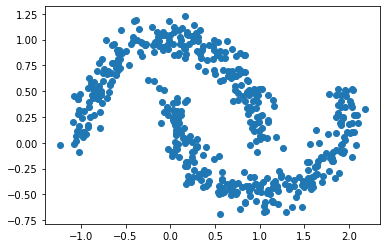

In [109]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

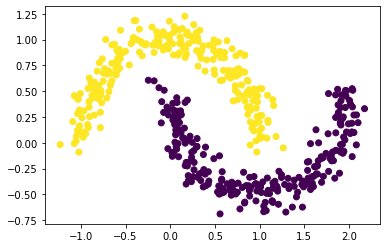

Wall time: 3.08 s


In [115]:
%%time
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

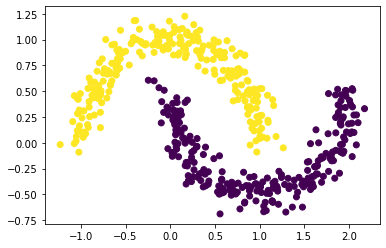

Wall time: 3.08 s


In [110]:
%%time
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

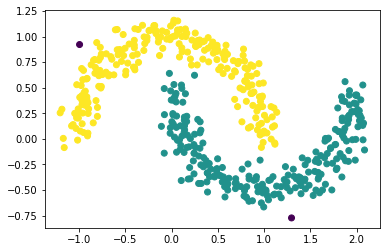

In [104]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



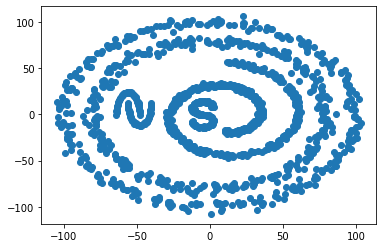

In [ ]:
# your code here


Или хотя бы что-нибудь такое: 

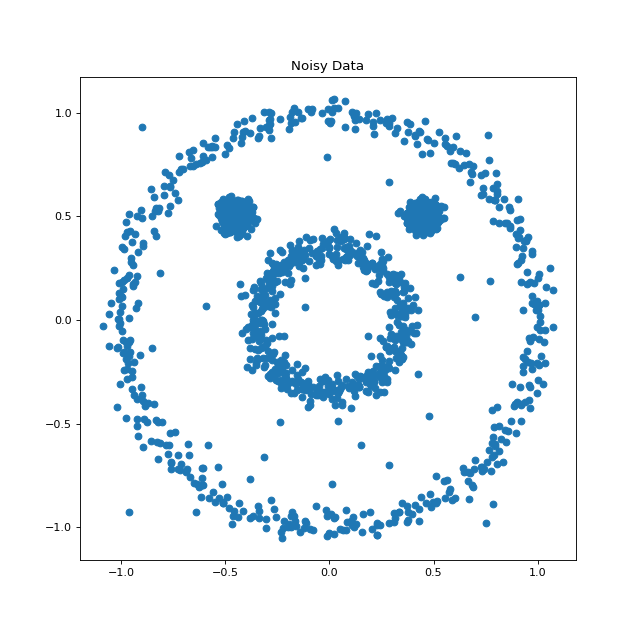

In [152]:
data = pd.read_csv('curves1.csv').to_numpy()

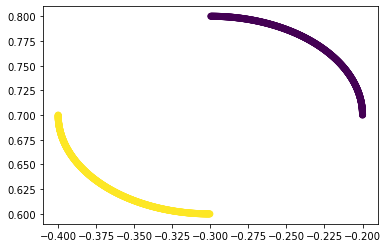

In [157]:
clusters = DBSCAN(eps=0.1, min_samples=2).fit_predict(data)
plt.scatter(data[:,0], data[:,1], c=clusters)
plt.show()

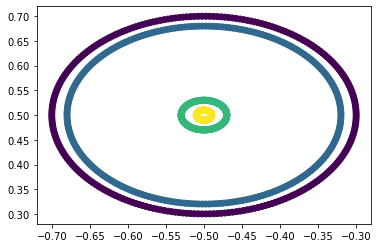

In [158]:
data = pd.read_csv('dartboard2.csv').to_numpy()
clusters = DBSCAN(eps=0.1, min_samples=2).fit_predict(data)
plt.scatter(data[:,0], data[:,1], c=clusters)
plt.show()

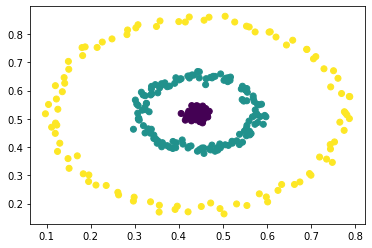

In [159]:
data = pd.read_csv('zelnik1.csv').to_numpy()
clusters = DBSCAN(eps=0.1, min_samples=2).fit_predict(data)
plt.scatter(data[:,0], data[:,1], c=clusters)
plt.show()

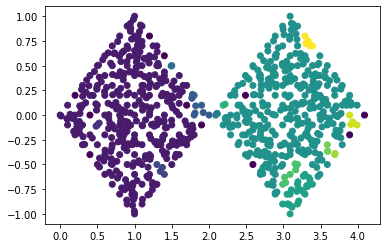

In [160]:
data = pd.read_csv('twodiamonds.csv').to_numpy()
clusters = DBSCAN(eps=0.1, min_samples=2).fit_predict(data)
plt.scatter(data[:,0], data[:,1], c=clusters)
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [717]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10, n_jobs=1000).fit_predict(X)

Wall time: 434 ms


In [694]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 2.9 s


$2900 \div 434 = 6.68 $

> Сделаем вид, что грязные хаки с многопоточностью в порядке вещей _:)_

> Если у Вас есть пример, как это сделать *красивее*, то не могли бы подсказать? Совсем не знаю, как изначально нужно было сделать эффективнее((

## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [226]:
X = pd.DataFrame(train[['Distance', 'DepTime']])

In [ ]:
X, X_valid, y_train_part, y_valid = train_test_split(X, y_train, test_size=0.3)
X

In [233]:
X

Distance  DepTime
74668       605     2050
8858        261     1730
4192        547     1001
57405       748     1859
19102       507      714
...         ...      ...
95125       410      807
31739       552     1050
50314       185     1428
11062       235     1346
97105       272     2001

[70000 rows x 2 columns]

### Сначала запустим DBSCAN без параметров. 

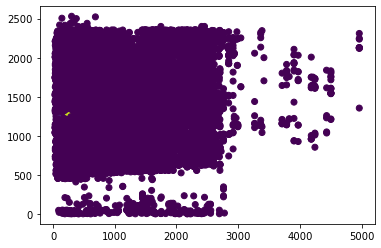

In [238]:
clusters = DBSCAN().fit_predict(X)

plt.scatter(X.Distance, X.DepTime, c=clusters)
plt.show()

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 


eps = 10, min_samples = 2


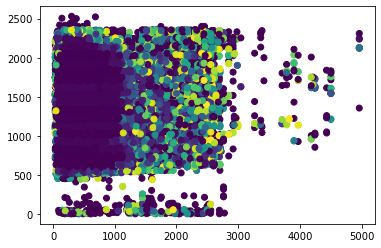


eps = 10, min_samples = 3


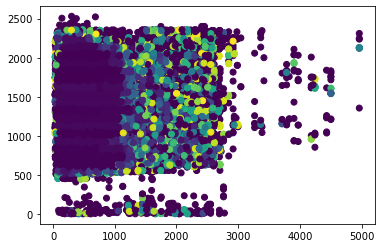


eps = 10, min_samples = 4


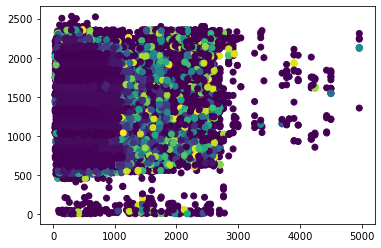


eps = 10, min_samples = 5


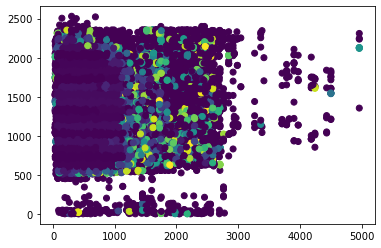


eps = 10, min_samples = 6


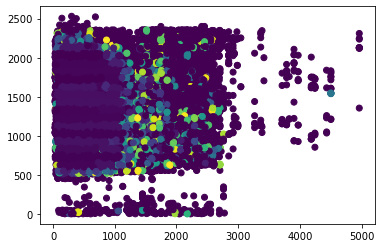


eps = 10, min_samples = 7


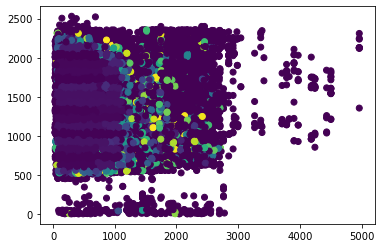


eps = 10, min_samples = 8


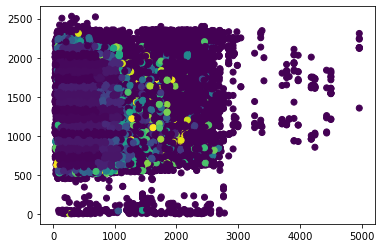


eps = 10, min_samples = 9


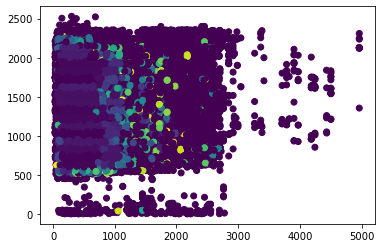


eps = 10, min_samples = 10


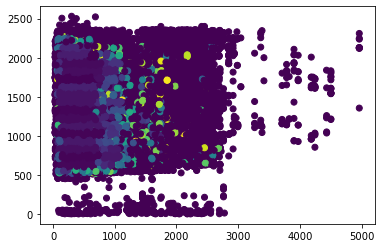


eps = 30, min_samples = 2


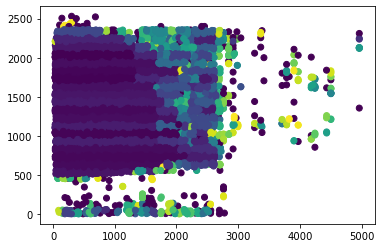


eps = 30, min_samples = 3


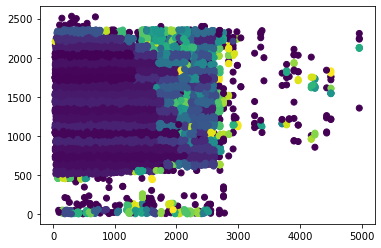


eps = 30, min_samples = 4


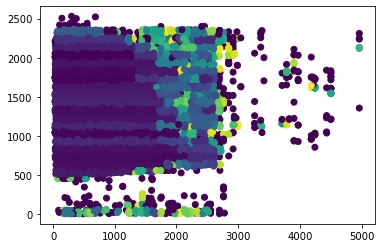


eps = 30, min_samples = 5


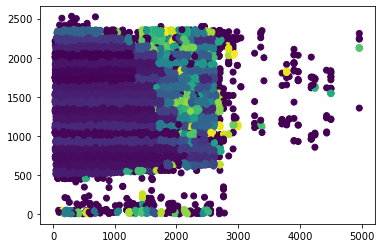


eps = 30, min_samples = 6


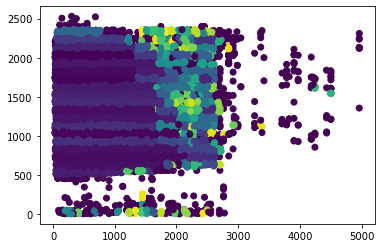


eps = 30, min_samples = 7


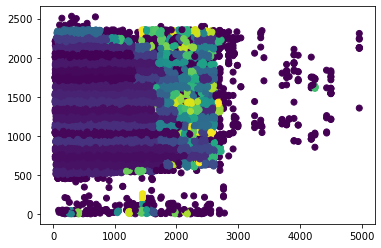


eps = 30, min_samples = 8


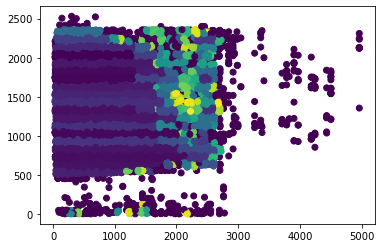


eps = 30, min_samples = 9


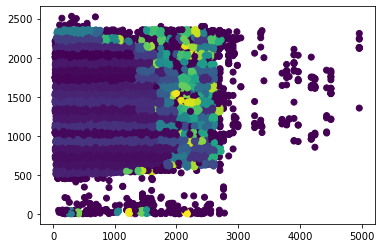


eps = 30, min_samples = 10


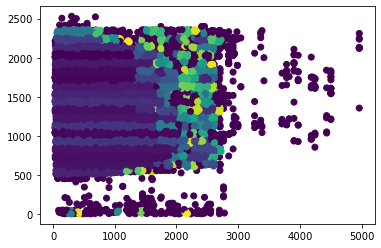


eps = 50, min_samples = 2


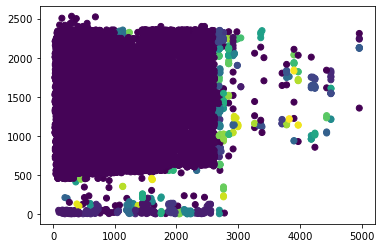


eps = 50, min_samples = 3


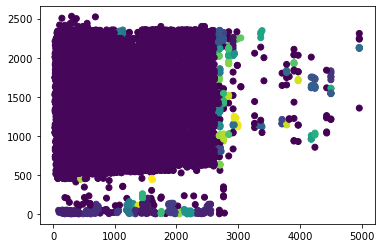


eps = 50, min_samples = 4


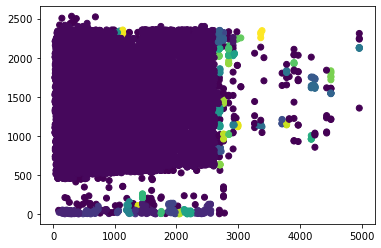


eps = 50, min_samples = 5


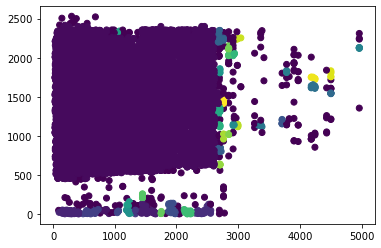


eps = 50, min_samples = 6


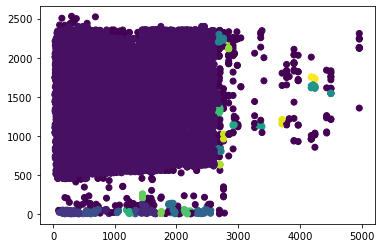


eps = 50, min_samples = 7


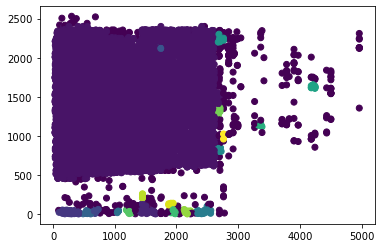


eps = 50, min_samples = 8


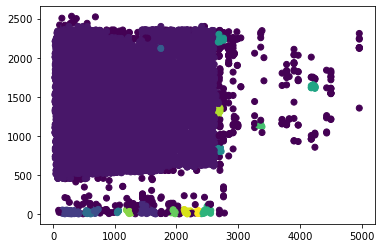


eps = 50, min_samples = 9


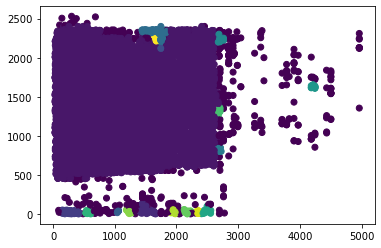


eps = 50, min_samples = 10


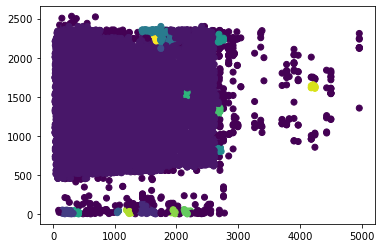


eps = 70, min_samples = 2


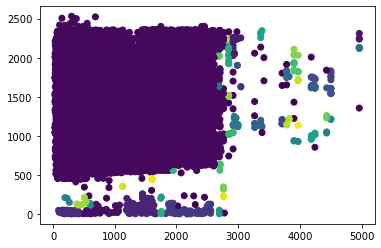


eps = 70, min_samples = 3


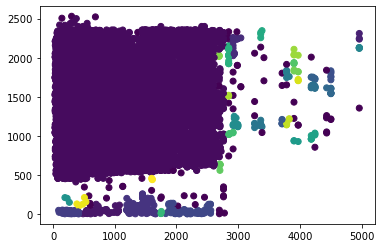


eps = 70, min_samples = 4


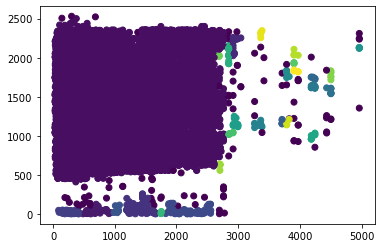


eps = 70, min_samples = 5


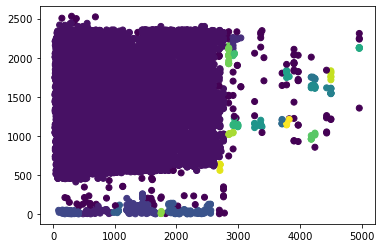


eps = 70, min_samples = 6


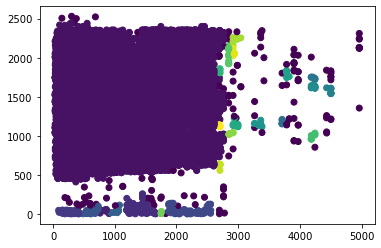


eps = 70, min_samples = 7


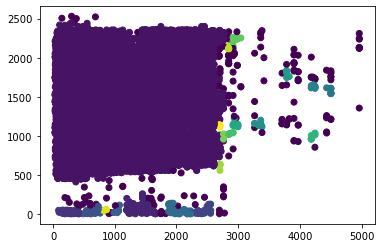


eps = 70, min_samples = 8


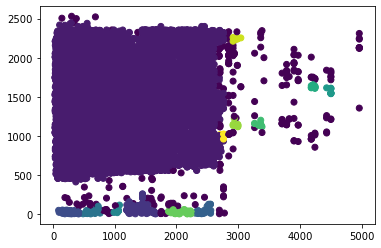


eps = 70, min_samples = 9


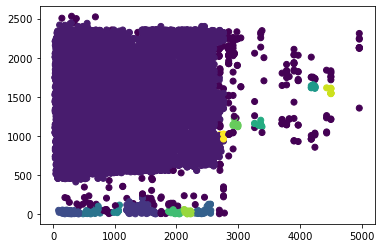


eps = 70, min_samples = 10


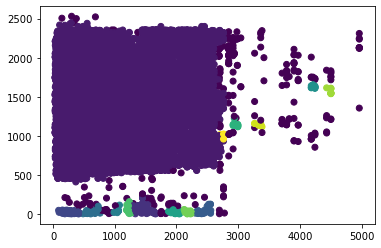


eps = 90, min_samples = 2


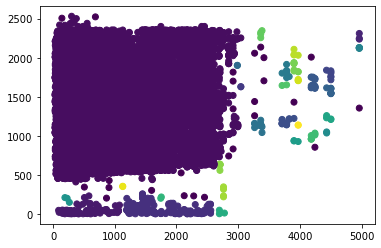


eps = 90, min_samples = 3


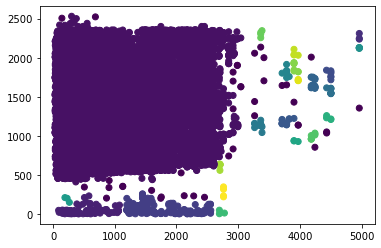


eps = 90, min_samples = 4


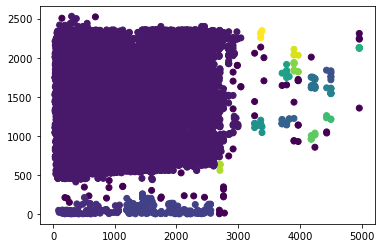


eps = 90, min_samples = 5


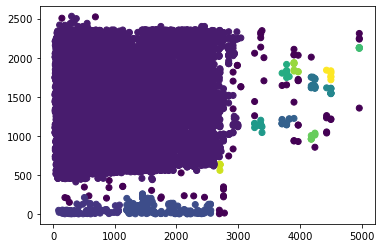


eps = 90, min_samples = 6


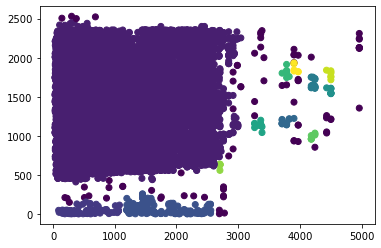


eps = 90, min_samples = 7


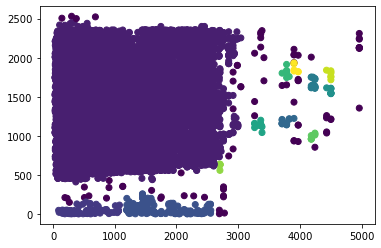


eps = 90, min_samples = 8


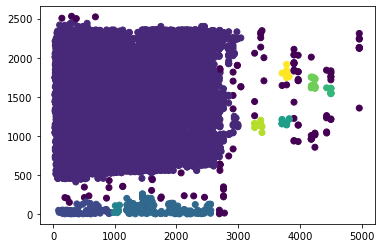


eps = 90, min_samples = 9


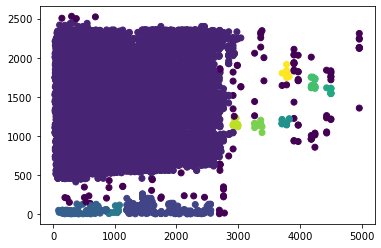


eps = 90, min_samples = 10


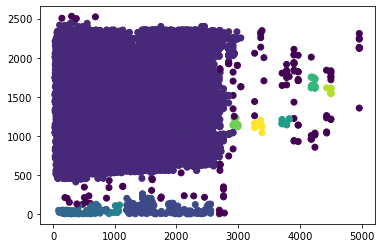


eps = 110, min_samples = 2


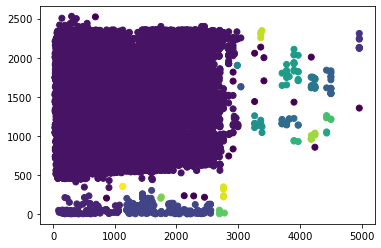


eps = 110, min_samples = 3


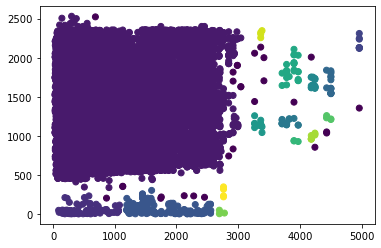


eps = 110, min_samples = 4


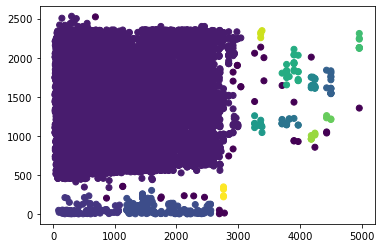


eps = 110, min_samples = 5


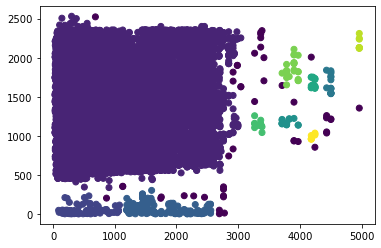


eps = 110, min_samples = 6


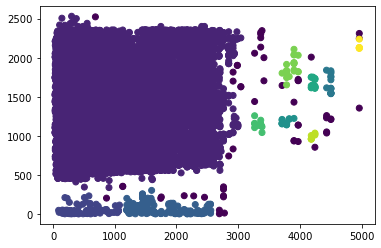


eps = 110, min_samples = 7


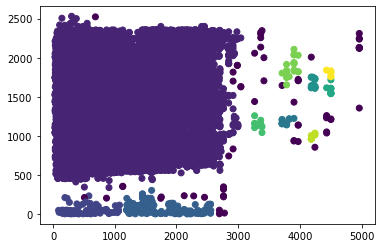


eps = 110, min_samples = 8


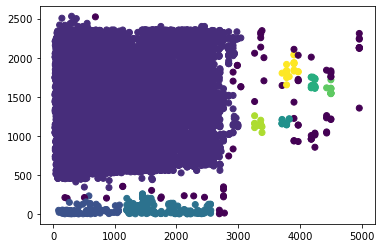


eps = 110, min_samples = 9


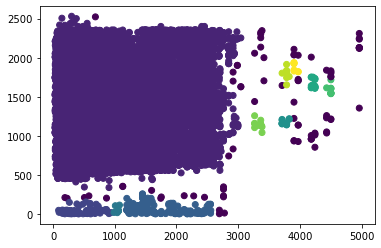


eps = 110, min_samples = 10


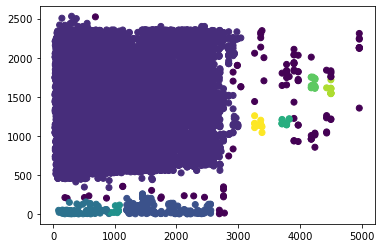


eps = 130, min_samples = 2


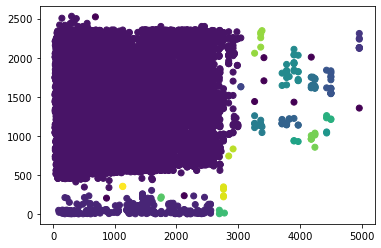


eps = 130, min_samples = 3


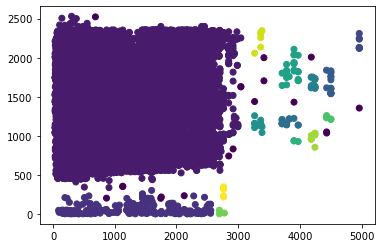


eps = 130, min_samples = 4


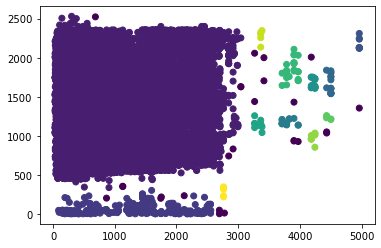


eps = 130, min_samples = 5


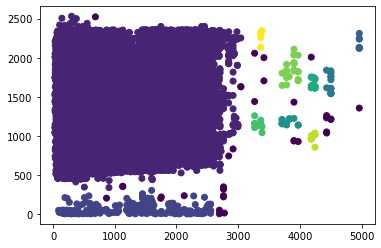


eps = 130, min_samples = 6


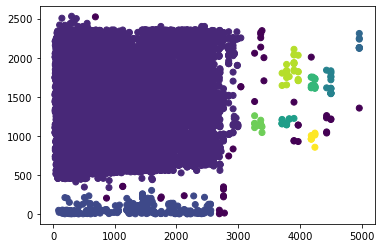


eps = 130, min_samples = 7


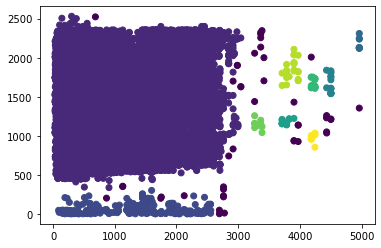


eps = 130, min_samples = 8


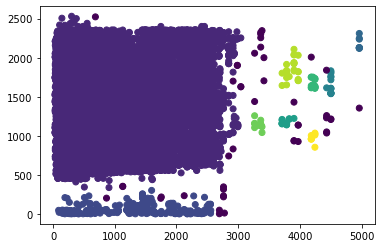


eps = 130, min_samples = 9


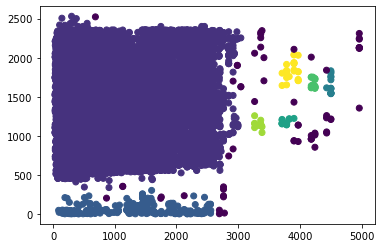


eps = 130, min_samples = 10


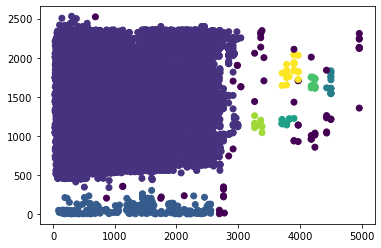


eps = 150, min_samples = 2


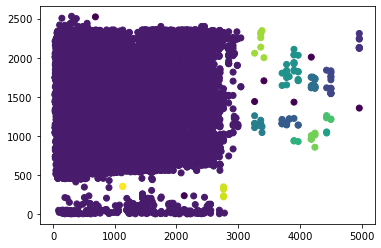


eps = 150, min_samples = 3


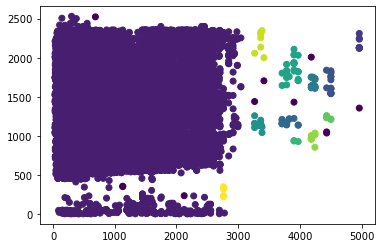


eps = 150, min_samples = 4


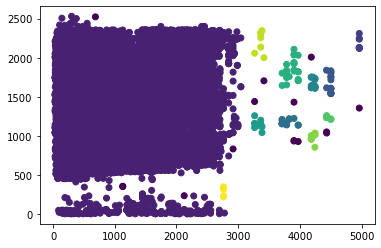


eps = 150, min_samples = 5


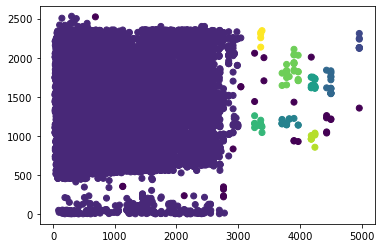


eps = 150, min_samples = 6


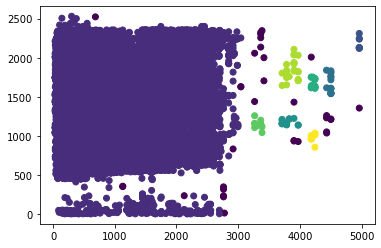


eps = 150, min_samples = 7


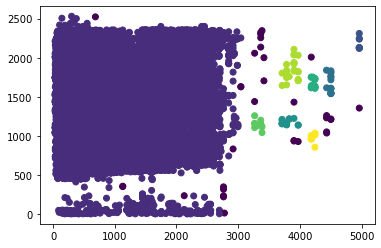


eps = 150, min_samples = 8


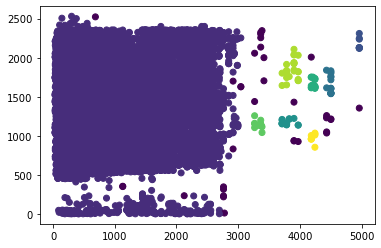


eps = 150, min_samples = 9


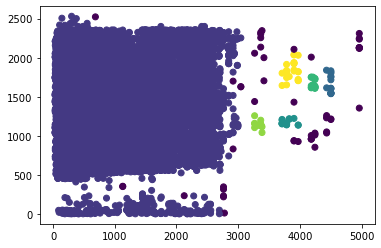


eps = 150, min_samples = 10


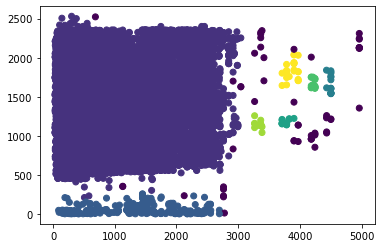


eps = 170, min_samples = 2


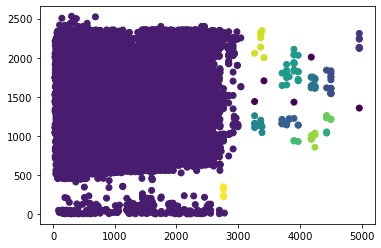


eps = 170, min_samples = 3


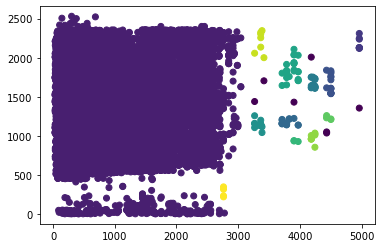


eps = 170, min_samples = 4


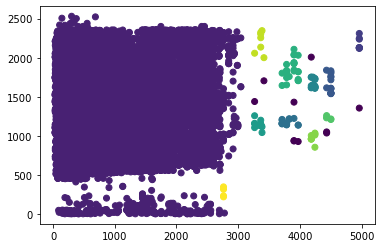


eps = 170, min_samples = 5


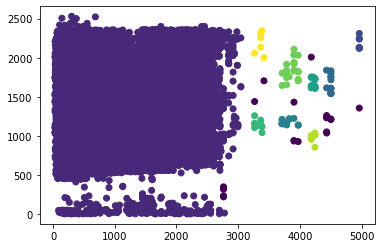


eps = 170, min_samples = 6


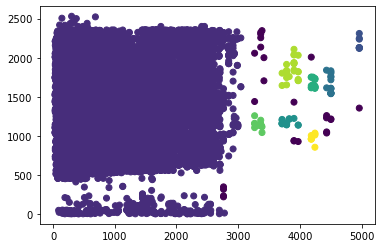


eps = 170, min_samples = 7


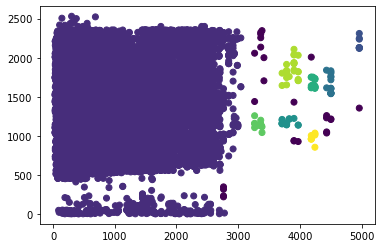


eps = 170, min_samples = 8


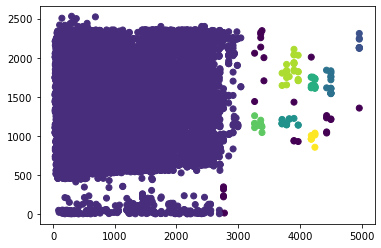


eps = 170, min_samples = 9


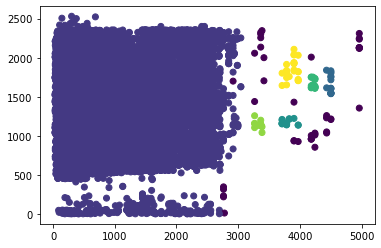


eps = 170, min_samples = 10


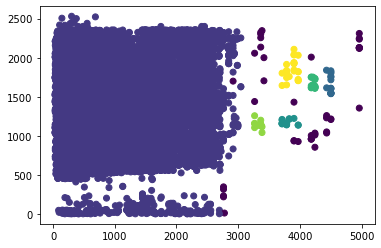


eps = 190, min_samples = 2


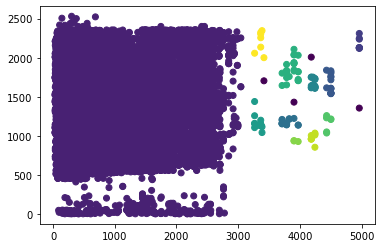


eps = 190, min_samples = 3


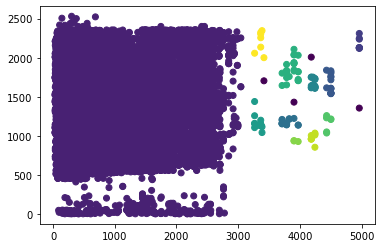


eps = 190, min_samples = 4


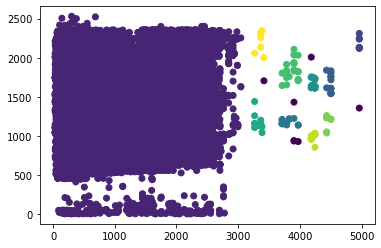


eps = 190, min_samples = 5


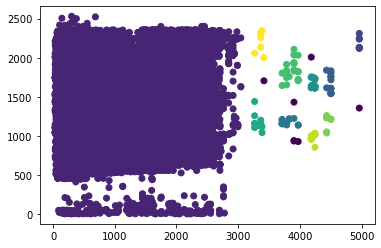


eps = 190, min_samples = 6


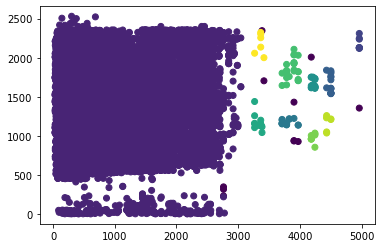


eps = 190, min_samples = 7


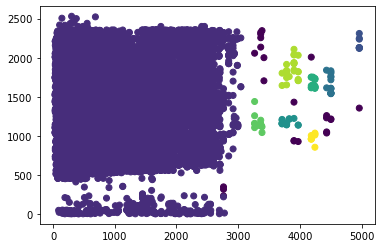


eps = 190, min_samples = 8


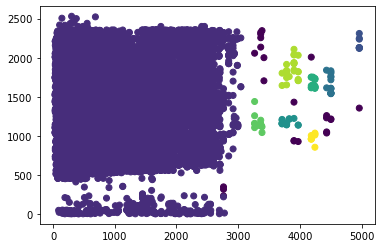


eps = 190, min_samples = 9


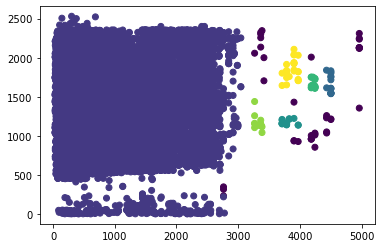


eps = 190, min_samples = 10


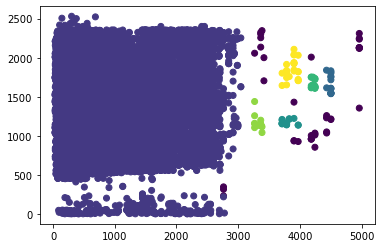


eps = 210, min_samples = 2


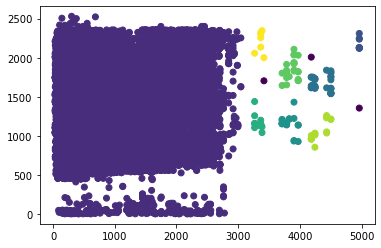


eps = 210, min_samples = 3


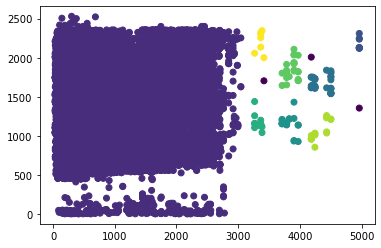


eps = 210, min_samples = 4


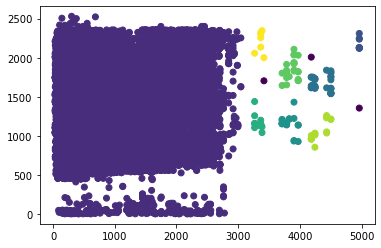


eps = 210, min_samples = 5


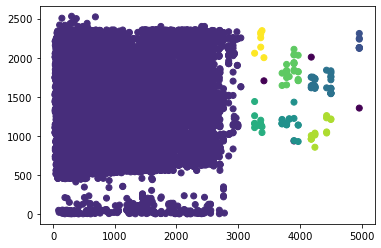


eps = 210, min_samples = 6


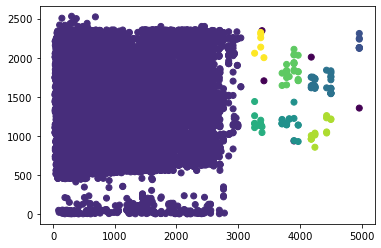


eps = 210, min_samples = 7


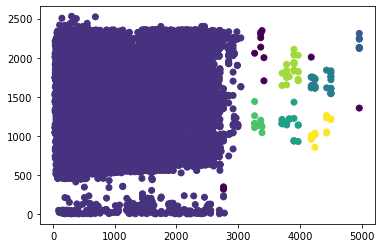


eps = 210, min_samples = 8


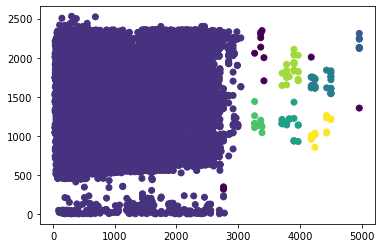


eps = 210, min_samples = 9


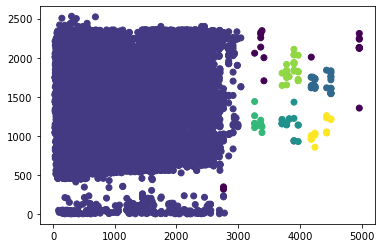


eps = 210, min_samples = 10


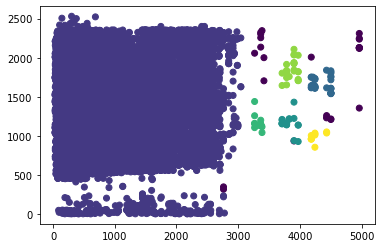


eps = 230, min_samples = 2


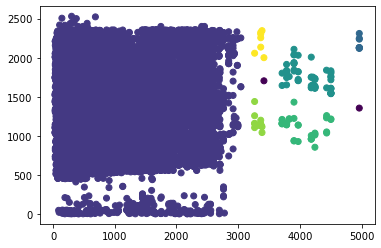


eps = 230, min_samples = 3


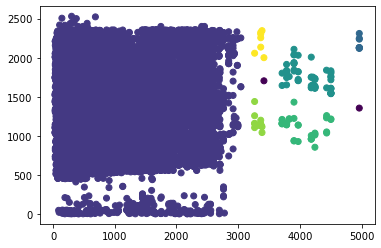


eps = 230, min_samples = 4


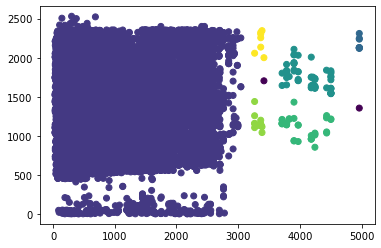


eps = 230, min_samples = 5


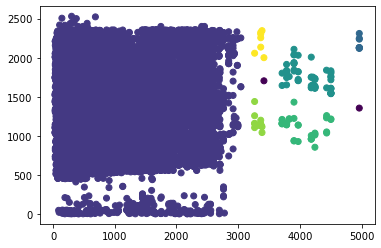


eps = 230, min_samples = 6


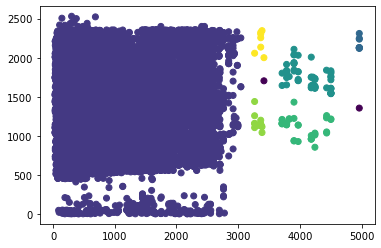


eps = 230, min_samples = 7


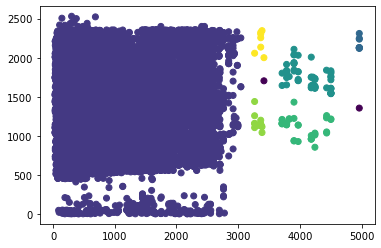


eps = 230, min_samples = 8


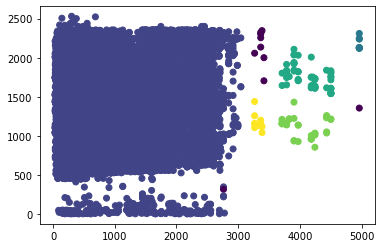


eps = 230, min_samples = 9


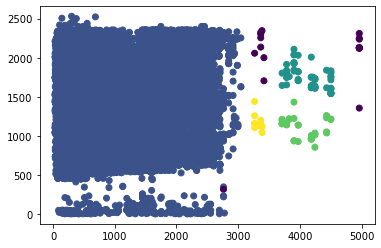


eps = 230, min_samples = 10


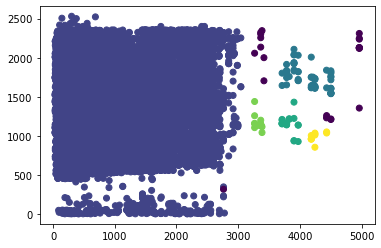


eps = 250, min_samples = 2


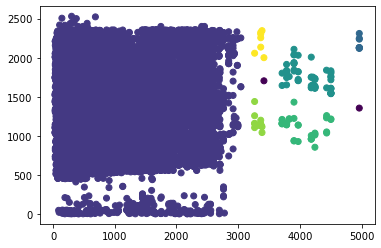


eps = 250, min_samples = 3


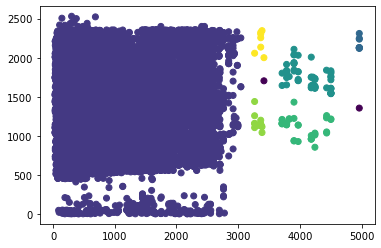


eps = 250, min_samples = 4


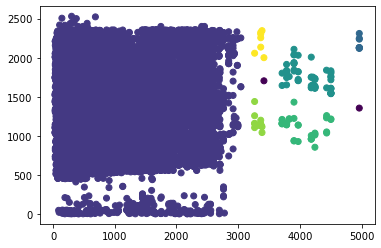


eps = 250, min_samples = 5


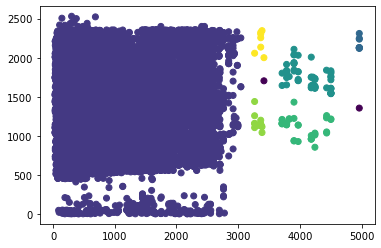


eps = 250, min_samples = 6


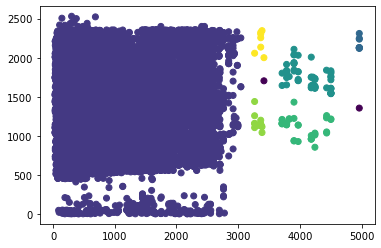


eps = 250, min_samples = 7


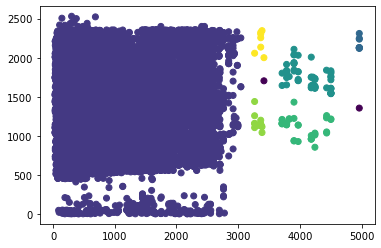


eps = 250, min_samples = 8


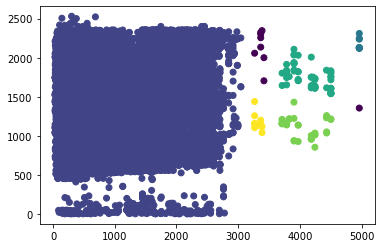


eps = 250, min_samples = 9


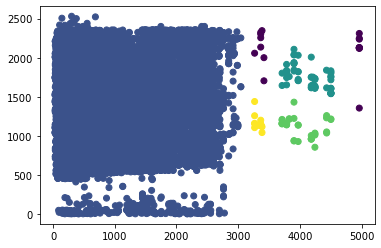


eps = 250, min_samples = 10


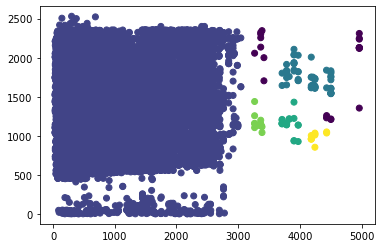


eps = 270, min_samples = 2


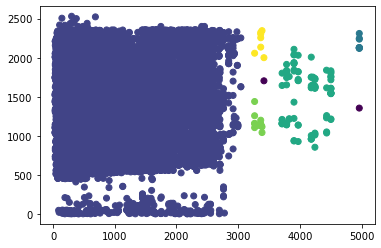


eps = 270, min_samples = 3


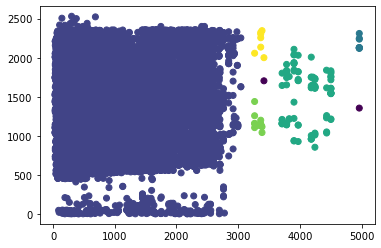


eps = 270, min_samples = 4


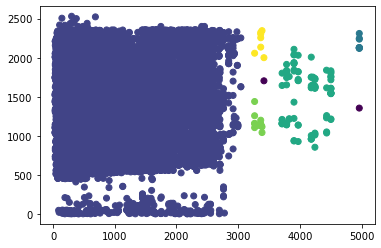


eps = 270, min_samples = 5


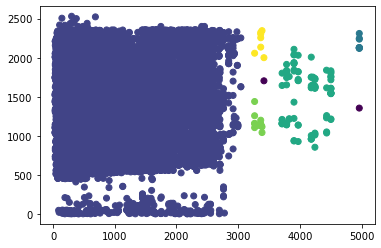


eps = 270, min_samples = 6


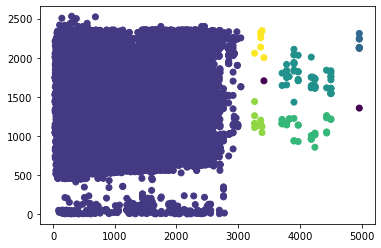


eps = 270, min_samples = 7


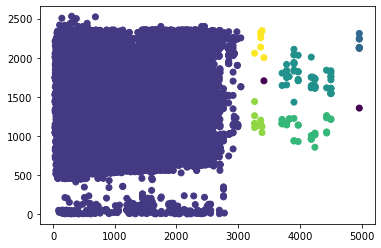


eps = 270, min_samples = 8


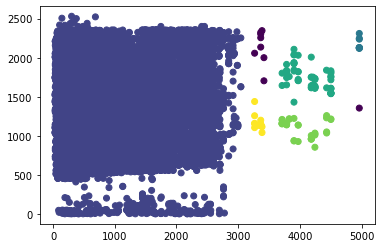


eps = 270, min_samples = 9


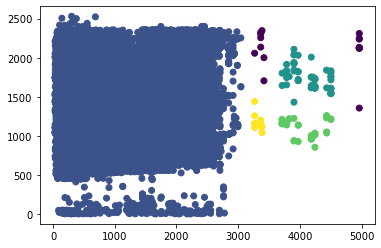


eps = 270, min_samples = 10


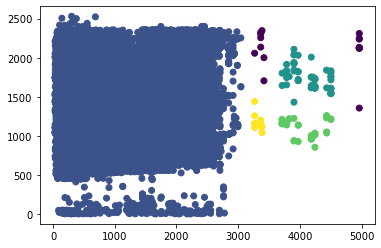


eps = 290, min_samples = 2


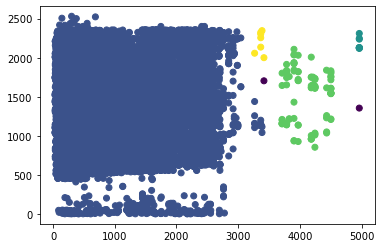


eps = 290, min_samples = 3


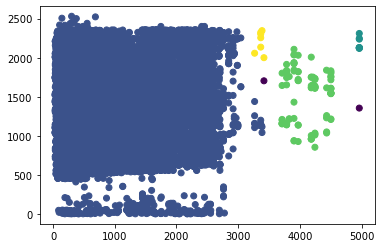


eps = 290, min_samples = 4


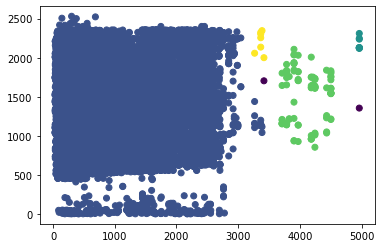


eps = 290, min_samples = 5


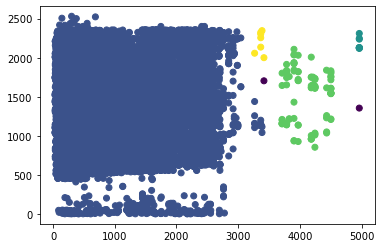


eps = 290, min_samples = 6


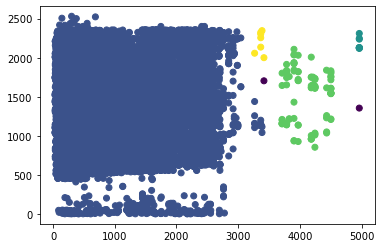


eps = 290, min_samples = 7


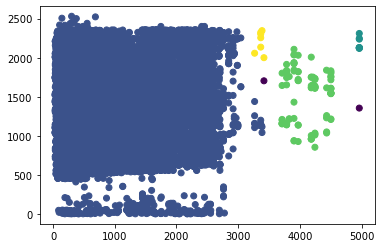


eps = 290, min_samples = 8


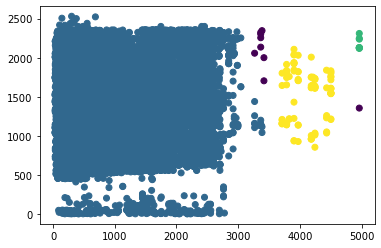


eps = 290, min_samples = 9


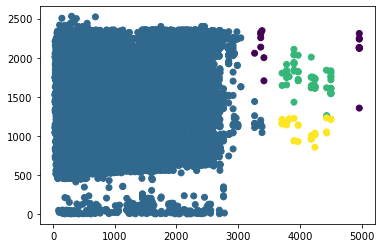


eps = 290, min_samples = 10


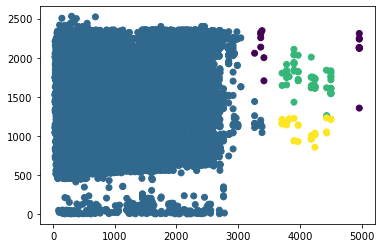

In [244]:
_eps = range(10, 300, 20)
_min_samples = range(2, 11, 1)

for eps in _eps:
    for min_samples in _min_samples:
        print(f"\n{eps = }, {min_samples = }")
        clusters = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
        plt.scatter(X.Distance, X.DepTime, c=clusters)
        plt.show()


> Больше всего шумовых точек при маленьком `eps` и относительно больших `min_samples`. Так происходит из-за того, что `eps` не даёт дотянуться до таких точек из больших кластеров. А маленький `min_samples` вынуждает нас выделять точки даже с большим количеством хороших соседей в отдельные классы. 

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

__Ответ:__